In [39]:
import matplotlib.pyplot as plt
import numpy as np

### Generate random hypothesis function $h$

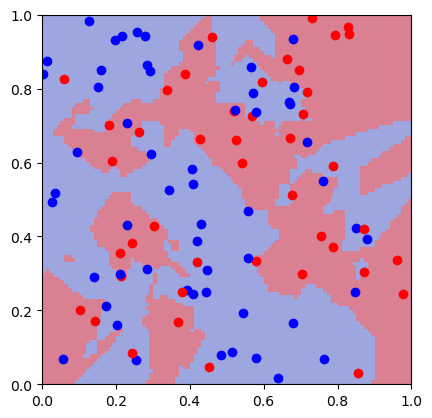

In [40]:
def generate_S():
    # sample 100 centres uniformly from [0, 1]^2
    centres = np.random.uniform(0, 1, size=(100, 2))
    # give each a random label from {0, 1}
    labels = np.random.choice([0, 1], size=100)
    return [centres, labels]

S = generate_S()

def h(x1, x2, S, v):  # slow version - not used anymore
    S = list(zip(S[0], S[1]))
    # find v nearest centres to (x1, x2) in S and take majority label
    distances_squared_with_labels = [((x1 - cx1) ** 2 + (x2 - cx2) ** 2, label) for (cx1, cx2), label in S]
    distances_squared_with_labels.sort(key=lambda pair: pair[0])    # note: keep labels attached
    v_nearest_labels = [label for _, label in distances_squared_with_labels[:v]]
    zero_count = sum(1 for label in v_nearest_labels if label == 0)
    if zero_count > v // 2:
        return 0
    elif zero_count < v // 2:
        return 1
    else:
        return np.random.choice([0, 1])  # tie-break randomly

def h_vectorised(X, S, v):  # much faster
    centres, labels = S
    # pairwise squared distances using broadcasting (diffs[i,j] = X[i] - centres[j])
    diffs = X[:, np.newaxis, :] - centres[np.newaxis, :, :]  # shape: (n_points, n_centers, 2)
    distances_sq = np.sum(diffs**2, axis=2)  # this axis is where the diffs in x1 coords and x2 coords are. 
    # (distances_sq[i,j] = (X[i,x1] - centres[j,x1])^2 + (X[i,x2] - centres[j,x2])^2). shape: (n_points, n_centers)
    # indices of v nearest neighbors (note doesn't sort fully, just get v smallest)
    nearest_indices = np.argpartition(distances_sq, v, axis=1)[:, :v]  # shape: (n_points, v)
    nearest_labels = labels[nearest_indices]  # shape: (n_points, v)
    zero_counts = np.sum(nearest_labels == 0, axis=1)
    # include tiebreak logic
    one_counts = v - zero_counts
    random_labels = np.random.choice([0, 1], size=X.shape[0])
    count_diffs = one_counts - zero_counts
    tiebreak = np.array(count_diffs == 0)   # 0 if same number of 0s and 1s
    # print("tiebreaks:", tiebreak.astype(int).sum())
    y_preds = (zero_counts <= v // 2).astype(int)   # note working with booleans
    y_preds_tiebreak = np.where(tiebreak, random_labels, y_preds)
    return y_preds_tiebreak

# split grid [0, 1]^2 into 100x100 cells
x1_vals = np.linspace(0, 1, 100)
x2_vals = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1_vals, x2_vals)
grid_points = np.column_stack([X1.ravel(), X2.ravel()])  # shape: (10000, 2)
# classify each cell using h
predictions = h_vectorised(grid_points, S, 3)
classified_cells = predictions.reshape(100, 100)    # for plotting
# plot the centres with the distribution over hypothesis
plt.imshow(classified_cells, extent=(0, 1, 0, 1), origin='lower', alpha=0.5, cmap='coolwarm')
S = list(zip(S[0], S[1]))
for (x1, x2), label in S:
    colour = 'red' if label == 1 else 'blue'
    plt.scatter(x1, x2, c=colour)
plt.show()

### Estimated generalisation error of k-NN as a function of k

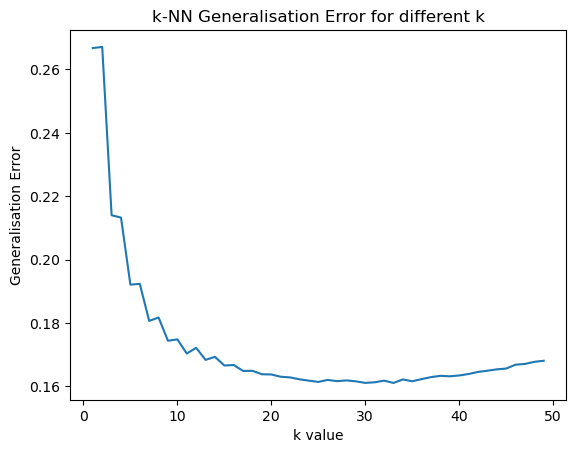

In [41]:
def sample_from_p_h(S, n):
    points = np.random.uniform(0, 1, size=(n, 2))    # sample xs uniformly at random
    # prepare when we will use h and random labels if we don't
    use_h = np.random.random(n) < 0.8    # array of booleans
    random_labels = np.random.choice([0, 1], size=n)
    h_predictions = h_vectorised(points, S, 3)
    # now fill labels
    labels = np.where(use_h, h_predictions, random_labels)  # use_h is like a bit mask
    return [points, labels]

def knn_vectorised_multi_k(X, S, k_values):
    # similar to h_vectorised but calculates labels for multiple k values at once
    centres, labels = S
    # pairwise squared distances using broadcasting (diffs[i,j] = X[i] - centres[j])
    diffs = X[:, np.newaxis, :] - centres[np.newaxis, :, :]  # shape: (n_points, n_centers, 2)
    distances_sq = np.sum(diffs**2, axis=2)  # this axis is where the diffs in x1 coords and x2 coords are. 
    # (distances_sq[i,j] = (X[i,x1] - centres[j,x1])^2 + (X[i,x2] - centres[j,x2])^2). shape: (n_points, n_centers)
    # indices of v nearest neighbors (note doesn't sort fully, just get v smallest)
    v = max(k_values)   # so prepared for all k
    nearest_indices = np.argpartition(distances_sq, v, axis=1)[:, :v]  # shape: (n_points, v)
    nearest_labels = labels[nearest_indices]  # shape: (n_points, v)
    # predictions for all k
    y_preds = []
    for k in k_values:
        k_nearest_labels = nearest_labels[:, :k]  # shape: (n_points, k)
        zero_counts = np.sum(k_nearest_labels == 0, axis=1)
        if k % 2 == 0:  # include tiebreak logic
            one_counts = k - zero_counts
            random_labels = np.random.choice([0, 1], size=X.shape[0])
            count_diffs = one_counts - zero_counts
            tiebreak = np.array(count_diffs == 0)   # 0 if same number of 0s and 1s
            y_preds_k = (zero_counts <= k // 2).astype(int)   # note working with booleans
            y_preds_k_tiebreak = np.where(tiebreak, random_labels, y_preds_k)
            y_preds.append(y_preds_k_tiebreak)
            continue
        y_preds.append((zero_counts <= k // 2).astype(int))
    return np.column_stack(y_preds)  # shape: (n_points, len(k_values))


# using protocol A - vectorised for efficiency

k_values = np.arange(1, 50)
n_runs = 100
error_matrix = np.zeros((len(k_values), n_runs))  # pre-allocate

for run in range(n_runs):
    # sample a h from p_H (generate random points and labels)
    S = generate_S()
    # build k-NN model with 4000 training pts sampled from p_h(x, y)
    training_pts = sample_from_p_h(S, 4000)
    # get curr gen_error for this run using 1000 test pts from p_h(x, y)
    # do for all k vals at once, using vectorised knn function
    test_pts = sample_from_p_h(S, 1000)
    test_pts_X = test_pts[0]
    test_pts_ys = test_pts[1]
    predictions_all_k = knn_vectorised_multi_k(test_pts_X, training_pts, k_values)  # shape: (1000, len(k_values))
    # error for a k is how many y_preds (inside predictions_all_k) differ from true ys (test_pts_ys), divided by total test pts
    error_matrix[:, run] = np.mean(predictions_all_k != test_pts_ys[:, np.newaxis], axis=0)  # mean error over test pts

generalisation_errors = np.mean(error_matrix, axis=1)  # mean over runs

plt.plot(k_values, generalisation_errors)
plt.xlabel('k value')
plt.ylabel('Generalisation Error')
plt.title('k-NN Generalisation Error for different k')
plt.show()

##### Graph explanation

This shape is due to the bias-variance tradeoff: gen_error = bias^2 + var + irreducible_error. For low k, the model overfits (low bias) to local changes of training set, leading to high variance and bad generalisation. Generalisation error decreases rapidly as k increases (possibly showing how k-NN is sensitive to noise reduction), as the model is less overfit (higher bias) but the variance decreases significantly. The optimal k region is here where the bias and variance are balanced. As k increases after 30, the model is too underfit, as the decision boundaries will be too smooth and simple, and the bias is larger so the generalisation error starts increasing slightly.

### Optimal k as a function of the number of training points

[100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
[22.93, 20.95, 24.34, 26.76, 26.92, 25.83, 26.3, 25.25, 26.96]


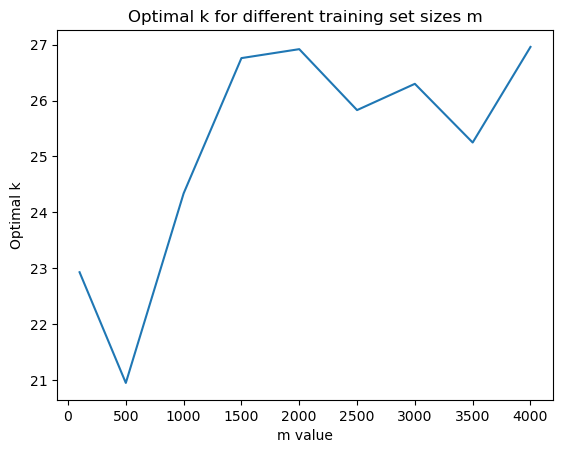

In [46]:
# using protocol B

m_values = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
optimal_ks = []
k_values = np.arange(1, 50)
n_runs = 100

for m in m_values:
    optimal_run_ks = np.zeros(n_runs)
    for run in range(n_runs):
        # sample a h from p_H (generate random points and labels)
        S = generate_S()
        # build k-NN model with 4000 training pts sampled from p_h(x, y)
        training_pts = sample_from_p_h(S, m)
        # get curr gen_error for this run using 1000 test pts from p_h(x, y)
        # do for all k vals at once, using vectorised knn function
        test_pts = sample_from_p_h(S, 1000)
        test_pts_X = test_pts[0]
        test_pts_ys = test_pts[1]
        predictions_all_k = knn_vectorised_multi_k(test_pts_X, training_pts, k_values)  # shape: (1000, len(k_values))
        # error for a k is how many y_preds (inside predictions_all_k) differ from true ys (test_pts_ys), divided by total test pts
        errors_for_ks = np.mean(predictions_all_k != test_pts_ys[:, np.newaxis], axis=0)  # mean error over test pts
        optimal_run_ks[run] = k_values[np.argmin(errors_for_ks)]
    optimal_ks.append(np.mean(optimal_run_ks))

print(m_values)
print(optimal_ks)
plt.plot(m_values, optimal_ks)
plt.xlabel('m value')
plt.ylabel('Optimal k')
plt.title('Optimal k for different training set sizes m')
plt.show()

##### Graph explanation

In general, the optimal k seems to increase with training set size. This is because as the training set size increases, the 2D space over [0, 1]^2 becomes more densely populated with points, so using more neighbours for classification is more statistically reliable. However, the graph is jumpy since there is high variance in the optimal k estimation, due to there being a different random p_H each run.